# Settings

In [ ]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep
import sys
sys.path.append('..' + sep_local + '..' + sep_local + '..') # For Windows import
os.chdir('..' + sep_local + '..' + sep_local + '..') # For Linux import
print(sep_local)

In [ ]:
import tensorflow as tf
print(tf.__version__)

#Dataset loading

In [ ]:
dataset_name='pacman'

In [ ]:
#images_dir = 'D:\\datasets\\Ms_Pacman\\Ms_Pacman\\Test\\'
images_dir = '/home/azeghost/datasets/.mspacman/atari_v1/screens/mspacman' #Linux
#images_dir = '..\..\..\\data\\atari_v1\\screens\\mspacman'
validation_percentage = 25
valid_format = 'png'

In [ ]:
from training.generators.file_image_generator import create_image_lists, get_generators

In [ ]:
imgs_list = create_image_lists(
    image_dir=images_dir, 
    validation_pct=validation_percentage, 
    valid_imgae_formats=valid_format
)

## downscalse the image into fifth

In [5]:
scale=5
image_size=(160//scale, 210//scale, 3)
batch_size = 5
EPIS_LEN = 10
EPIS_SHIFT = 5

In [6]:
#we created new  class_mode  episode_flat witch returns 
#da.from_array(np.reshape(batch_x, (-1,)+self.image_shape )), da.from_array(np.reshape(batch_gt, (-1,)+self.image_shape))

  INFO     | Found 33971 training files


  INFO     | Found 12408 validation files


In [7]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=images_dir, 
    image_size=image_size, 
    batch_size=batch_size, 
    class_mode='episode_flat', 
    episode_len=EPIS_LEN, 
    episode_shift=EPIS_SHIFT
)

In [8]:
import tensorflow as tf
import numpy as np

In [9]:
#changed output shapes of Dataset Generators 
#from (batch_size, EPIS_LEN, ) + image_size)
#to (batch_size* EPIS_LEN, ) + image_size) 

In [10]:
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen, 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((batch_size* EPIS_LEN, ) + image_size), 
                   tf.TensorShape((batch_size* EPIS_LEN, ) + image_size)
                  )
)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_gen,     
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((batch_size* EPIS_LEN, ) + image_size), 
                   tf.TensorShape((batch_size* EPIS_LEN, ) + image_size)
                  )
)


In [11]:
dataset_name = 'atari_v1_Pacman'

In [ ]:
intermediate_dim = 10
inputs_shape= image_size # image shape
LATENT_DIM = 10

In [12]:
inputs_shape

(10, 80, 105, 3)

In [13]:
tdConv = lambda **kwds: tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(**kwds))

In [14]:
tdDeConv = lambda **kwds: tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(**kwds))

In [15]:
tdDense = lambda **kwds: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(**kwds))

In [17]:
c = 3

In [18]:
#tf.keras.layers.ConvLSTM2D

In [19]:
enc_mean_lays = [
    tdConv(filters=c, kernel_size=3, strides=(2, 2), activation='relu'),
    tdConv(filters=2*c, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(LATENT_DIM)
]

enc_var_lays = [
    tdConv(filters=c, kernel_size=3, strides=(2, 2), activation='relu'),
    tdConv(filters=2*c, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(LATENT_DIM)
]



dec_lays = [
    tf.keras.layers.Dense(units=c**3, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(1, c, c, c)),
    tdDeConv(filters=2*c, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tdDeConv(filters=c, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tdDeConv(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),    
]

In [20]:
model_name = 'Atari_VAE_Basic_convlstm'

In [21]:
import os
#experiments_dir='..'+sep_local+'..'+sep_local+'..'+sep_local+'experiments'+sep_local + model_name
experiments_dir=os.getcwd()+ sep_local  +'experiments'+sep_local + model_name

In [22]:
from os.path import abspath
absolute = abspath(experiments_dir)
print("Recording_dir",absolute)
print("Current working dir",os.getcwd())

'..\\experiments\\Atari_VAE_B_convlstm\\Atari_VAE_B_convlstm'

In [23]:
#from training.autoencoders_conditional.Cond_AE import CondAE as AE
from training.autoencoding_basic.autoencoders.VAE import VAE as AE

In [25]:
variables_params = \
[
    {
        'name': 'inference_mean', 
        'inputs_shape':inputs_shape,
        'outputs_shape':LATENT_DIM,
        'layers': enc_mean_lays
    }
    ,
    
     {
        'name': 'inference_logvariance', 
        'inputs_shape':inputs_shape,
        'outputs_shape':LATENT_DIM,
        'layers':enc_var_lays
    }
    ,
    
        {
        'name': 'generative', 
        'inputs_shape':LATENT_DIM,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [26]:
from utils.data_and_files.file_utils import create_if_not_exist
_restore = os.path.join(experiments_dir, 'var_save_dir')
create_if_not_exist(_restore)
absolute = abspath(_restore)
print("Restore_dir",absolute)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



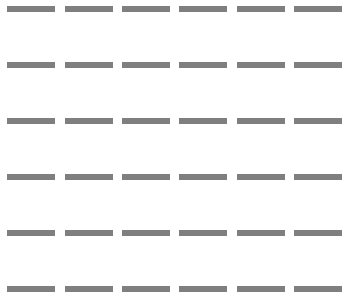

  ERROR    | No former training found ... 
Epochs Progress:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

  INFO     | Training ... 
Epochs Progress, Training Iterations 4:   0%|                                                   | 0/10 [00:19<?, ?it/s]

KeyboardInterrupt: 

In [31]:
ae = AE( 
    name=model_name,
    inputs_shape= inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=LATENT_DIM,
    variables_params=variables_params, 
    filepath=None
    )

In [ ]:
ae.compile(metrics=None)

In [ ]:
train_ds


In [ ]:

from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

In [ ]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [ ]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, model_name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
absolute = abspath(csv_dir)
print("Csv_dir",absolute)

In [ ]:
image_gen_dir = os.path.join(experiments_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)
absolute = abspath(image_gen_dir)
print("Image_gen_dir",absolute)

In [ ]:
sg = SampleGeneration(latent_shape=LATENT_DIM, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=True)

In [ ]:
ae.fit(
    x=train_ds,
    steps_per_epoch=1000,
    epochs=100, 
    verbose=1,
    callbacks=[ es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True
)